## Imports

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torch.backends import cudnn
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

## Dataset class

In [2]:
class TimeseriesDataset(Dataset):   
    def __init__(self, ds, mean, std, input_window = 10, output_window=1):
        self.ds = ds
        self.input_window = input_window
        self.output_window = output_window
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.ds) - (self.input_window + self.output_window)

    def __getitem__(self, index):
        return (self.normalize(self.ds[index:index + self.input_window]), 
                self.ds[index + self.input_window:index + self.input_window + self.output_window])
        
    def normalize(self, features):
      features = (features - self.mean)/(self.std + 1e-6)
      return features

## Transformer

### Positional Econding

In [3]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, position, d_model, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        angle_rads = get_angles(np.arange(position)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)
        angle_rads = torch.from_numpy(angle_rads)
        angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])
        pe = angle_rads.unsqueeze(0).float()
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

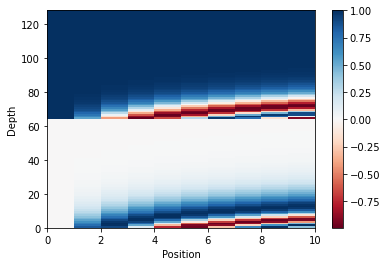

In [5]:
n,d = 10, 128
positions = torch.zeros(d, dtype= torch.float32).expand(1, n,d)
layer_encoding = PositionalEncoding(n,d,0)
pos_encoding = layer_encoding(positions)
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

### Self attention block

In [6]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size//heads
    #assert (self.head_dim * heads == embed_size), "Window size can not be divisible for heads"

    self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.fc_out = nn.Linear(self.head_dim * heads, embed_size)
    
  def forward(self, values, keys, query, mask = None):
    batch_size = query.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
    # values, keys, query shape: (batch_size, window_enc, embed_size) = (64, 10, 256)

    #split window into self.heads pieces
    values = values.reshape(batch_size, value_len, self.heads, self.head_dim) #batch_size, self.heads, head dove window_size = self.heads*head
    keys = keys.reshape(batch_size, key_len, self.heads, self.head_dim)
    queries = query.reshape(batch_size, query_len,  self.heads, self.head_dim)
    # values, keys, query shape: (batch_size, window_enc, heads, head_dim) = (64, 10, 8, 32)

    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)
    # same shapes of the previous step
    
    energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) 
    #energy shape: (batch_size, heads, query_len, key_len) = (64, 8, 10, 10) during encoding

    if mask is not None:
      energy = energy.masked_fill(mask == float("-inf"), float("-1e20"))
    
    attention = torch.softmax(energy/ (self.embed_size ** 0.5), dim=3)
    attention_weight = attention
    out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
        batch_size, query_len, self.embed_size
    )
    #out: (batch_size, query_len, heads, head_dim) ->reshape-> (N, query_len, heads head)
    #out encoding (64,10,256)
    out = self.fc_out(out)
    return out, attention_weight

### Transformer Block

In [7]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout=0.1, forward_expansion=1, skip_connection_type=0):
    super(TransformerBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)
    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion * embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion * embed_size, embed_size)
    )
    self.dropout = nn.Dropout(dropout)

    self.operation=torch.add
    self.layer_skip_1 = nn.Identity(requires_grad=False)
    self.layer_skip_2 = nn.Identity(requires_grad=False)
    self.scalar_1 = nn.Parameter(torch.tensor(1.), requires_grad=False)
    self.scalar_2 = nn.Parameter(torch.tensor(1.), requires_grad=False)

    if skip_connection_type==1:
      self.operation=torch.mul
      self.layer_skip_1 = nn.Linear(embed_size, embed_size)
      self.layer_skip_2 = nn.Linear(embed_size, embed_size)
    elif skip_connection_type==2:
      self.operation=torch.mul
      self.scalar_1 = nn.Parameter(torch.randn(1))
      self.scalar_2 = nn.Parameter(torch.randn(1))
    elif skip_connection_type==3:
      self.operation=torch.mul

  def forward(self, value, key, query, mask = None):

    attention, attention_weight = self.attention(value, key, query, mask)
    skip_component_1 = self.scalar_1 * self.layer_skip_1(query)

    x = self.norm1(self.operation(attention, skip_component_1)) #implement also the skip connection
    # Encoder shape: (batch_size, window_enc, heads, head_dim) = (64, 10, 256)
    x = self.dropout(x)
    forward = self.feed_forward(x)
    # Encoder shape: (batch_size, window_enc, head_dim) = (64, 10, 256)  --> (batch_size, window_enc, head_dim * forward_expansion) --> (batch_size, window_enc, head_dim)
    
    skip_component_2 = self.scalar_2 * self.layer_skip_2(x)
    
    out = self.norm2(self.operation(forward, skip_component_2))
    out = self.dropout(out)
    return out, attention_weight

### Encoder

In [8]:
class Encoder(nn.Module):
  def __init__(
      self,
      window_size,
      feature_size,
      embed_size,
      num_layers,
      heads,
      forward_expansion=1,
      dropout=0.1,
      skip_connection_type=0,
      ):
    super(Encoder, self).__init__()
    self.embed_size = embed_size
    self.window_size = window_size
    self.feature_embeding = nn.Linear(feature_size, embed_size)
    self.position_embedding = PositionalEncoding(window_size, embed_size)
    
    self.layers = nn.ModuleList(
        [
          TransformerBlock(embed_size, heads, dropout, forward_expansion, skip_connection_type) for _ in range(num_layers)
        ]
    )

  def forward(self, x):
    mask = self.build_attention_mask()
    x = self.feature_embeding(x)
    out = self.position_embedding(x)
    
    for layer in self.layers:
      out, _ = layer(out, out, out, mask)
    return out

  def build_attention_mask(self):
        mask = torch.empty(self.window_size, self.window_size)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask.to(DEVICE)

## Model architecture

In [9]:
class TimeModel(nn.Module):
  def __init__(
      self,
      input_window_size,
      output_window_size,
      feature_size,
      embed_size,
      num_layers,
      heads,
      forward_expansion=1,
      dropout=0.1,
      skip_connection_type=0,
      ):
    super(TimeModel, self).__init__()
    
    self.encoder = Encoder(
        input_window_size,
        feature_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        skip_connection_type
    ) 

    self.mlp_proj = nn.Sequential(
        nn.Linear(embed_size, embed_size//4),
        nn.ReLU(),
    )
    self.output_window_size=output_window_size
    self.feature_size = feature_size

    self.mlp_out = nn.Linear(embed_size//4 * input_window_size, output_window_size * feature_size)

  def forward(self, x):
    batch_size = x.shape[0]

    x = self.encoder(x)
    x = self.mlp_proj(x).view(batch_size, -1)
    return self.mlp_out(x).view(batch_size, self.output_window_size, self.feature_size)

## Parameters

In [10]:
WINDOW_SIZE_INPUT = 10
WINDOW_SIZE_OUTPUT = 4
LR = 1e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 2
EPSILON = 1e-9
BETA1 = 0.9
BETA2 = 0.98
BATCH_SIZE = 64
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  DEVICE = "cuda"
else:
  DEVICE = "cpu"

Tesla T4


## Download and split the data

In [11]:
original_path = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
filename = 'jena_climate_2009_2016.csv.zip'
zip_path = tf.keras.utils.get_file(origin=original_path, 
                                   fname=filename, 
                                   extract = True, 
                                   cache_dir='.', 
                                   cache_subdir='data')
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
columns_indices = [2,5]  #temperature and humidity
columns = df.columns[columns_indices]
data = df[columns].values.astype(np.float32)

In [12]:
n = len(data)
train_data = data[0:int(n*0.85)]
val_data = data[int(n*0.85):int(n*0.95)]
test_data = data[int(n*0.95):]

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

In [13]:
def prepare_the_laoders(train_data, val_data, test_data, input_window=WINDOW_SIZE_INPUT):
  train_dataset = TimeseriesDataset(train_data, mean, std, input_window = input_window, output_window = WINDOW_SIZE_OUTPUT)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=False)

  val_dataset = TimeseriesDataset(val_data, mean, std, input_window = input_window, output_window = WINDOW_SIZE_OUTPUT)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last=False)

  test_dataset = TimeseriesDataset(test_data, mean, std, input_window = input_window, output_window = WINDOW_SIZE_OUTPUT)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last=False)

  return train_loader, val_loader, test_loader

## Create the model

In [14]:
def update_lr(step):
  #print(step)
  arg1 = (step+1) ** -0.5
  arg2 = step * (2500 ** -1.5)
  return 1024.0**-0.5 * min(arg1, arg2)

In [15]:
def count_number_of_parameters(model):
  train_num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  fized_num_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

  print(f"Number of Trainable parameters: {train_num_params}\nNumber of NON trainable parameters: {fized_num_params}")

In [16]:
def create_model(
                  skip_connection_type=0, 
                  input_window_size=WINDOW_SIZE_INPUT, 
                  output_window_size = WINDOW_SIZE_OUTPUT
                 
                ):
  np.random.seed(0)
  torch.manual_seed(0)

  model = TimeModel(
                      input_window_size = input_window_size,
                      output_window_size = output_window_size,
                      feature_size = 2,
                      embed_size = 256,
                      num_layers=1,
                      forward_expansion = 2,
                      heads = 8,
                      dropout = 0.1,
                      skip_connection_type=skip_connection_type
                    )


  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(),lr=1, betas=(BETA1, BETA2), eps=EPSILON)
  scheduler = LambdaLR(optimizer, lr_lambda=update_lr, verbose = False)
  model.to(DEVICE)
  cudnn.benchmark = True

  count_number_of_parameters(model)
  
  return model, criterion, optimizer, scheduler

## Training functions

In [17]:
def evaluation(model_eval, loader, criterion):
  model_eval.eval()
  t_iter = iter(loader)
  i = 0
  total_loss = 0

  with torch.no_grad():
    for enc_src, y in t_iter:
      enc = enc_src.to(DEVICE)
      y_target = y.to(DEVICE)

      y_pred = model_eval(enc) 
      total_loss += criterion(y_target, y_pred).item()
      i+=1
      
  return total_loss/i

In [18]:
def train_model(model, train_loader, val_loader, test_loader, criterion, scheduler, optimizer):
  
  best_val_loss = float("inf")
  best_model = model

  for epoch in range(NUM_EPOCHS):
    model.train()
    d_iter = iter(train_loader)
    step = 0
    for enc_src, y in tqdm(d_iter):
        
        # zero the gradients
        model.zero_grad()
        
        enc_src = enc_src.to(DEVICE)
        y_train = y.to(DEVICE)
        
        # Pass the inputs through the transformer model.
        y_pred = model(enc_src)

        # Calculate the batch loss
        loss = criterion(y_pred, y_train)
        
        # Backward pass
        loss.backward()
        if (step % 1000 == 0) or (step==len(train_loader)-1):
          val_loss = evaluation(model, val_loader, criterion)
          print(f"Epoch: {epoch+1}, step: {step}, Train-loss: {loss.item()}, Val-Loss {val_loss}, LR: {scheduler.get_last_lr()[0]}")
          if best_val_loss > val_loss:
            best_val_loss = val_loss
            best_model = model
          
        # Update the parameters in the optimizer
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
        optimizer.step()
        step += 1
        scheduler.step()

  mse = evaluation(best_model, test_loader, criterion)
  return mse, best_model

## TRAIN

In [19]:
diz = {
    0:"Additional Skip Connection",
    1:"Multiplicative Skip Connection + Linear",
    2:"Multiplicative Skip Connection + Scalar",
    3:"Multiplicative Skip Connection"
}

In [20]:
results = [["Type", "MSE on test set", "Input_window_size"]]
windows_size = [100, 30, 10]
best_models = []

for i in range(4):
  for window in windows_size:
    print(f"--------- {diz[i]} with {window} as input window ---------")
    model, criterion, optimizer, scheduler = create_model(skip_connection_type=i, input_window_size=window)
    train_loader, val_loader, test_loader = prepare_the_laoders(train_data, val_data, test_data, input_window=window)
    mse, best_model = train_model(model, train_loader, val_loader, test_loader, criterion, scheduler, optimizer)
    best_models.append(best_model)
    results.append([diz[i], mse, window])

--------- Additional Skip Connection with 100 as input window ---------
Number of Trainable parameters: 401224
Number of NON trainable parameters: 2


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 2896.79248046875, Val-Loss 3073.6896807042563, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 5.201371192932129, Val-Loss 4.9405900103426195, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 3.118765354156494, Val-Loss 4.1723133915262975, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 4.24170446395874, Val-Loss 3.426627710189034, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 3.316370725631714, Val-Loss 2.7471741380896875, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 2.6605610847473145, Val-Loss 2.6672835546295817, LR: 0.00044189755069578944
Epoch: 1, step: 5583, Train-loss: 1.9684975147247314, Val-Loss 2.741268918622376, LR: 0.0004181935371657728


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 17.38018035888672, Val-Loss 2.7719120769193624, LR: 0.0004181560964980613
Epoch: 2, step: 1000, Train-loss: 1.354759693145752, Val-Loss 2.6474967342119937, LR: 0.00038509877047586085
Epoch: 2, step: 2000, Train-loss: 1.7751448154449463, Val-Loss 2.5434116486959706, LR: 0.0003588163541496869
Epoch: 2, step: 3000, Train-loss: 1.443907618522644, Val-Loss 2.499955899422852, LR: 0.00033727167690444096
Epoch: 2, step: 4000, Train-loss: 3.3786659240722656, Val-Loss 2.428208610928822, LR: 0.00031919344428952895
Epoch: 2, step: 5000, Train-loss: 3.199936628341675, Val-Loss 2.3748241069033833, LR: 0.00030374181973546484
Epoch: 2, step: 5583, Train-loss: 2.2158596515655518, Val-Loss 2.8039049606588557, LR: 0.00029570748597830646
--------- Additional Skip Connection with 30 as input window ---------
Number of Trainable parameters: 365384
Number of NON trainable parameters: 2


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 3137.30859375, Val-Loss 3085.7793765830124, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 3.6790671348571777, Val-Loss 3.7525749441967706, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 3.678847312927246, Val-Loss 4.040247092780457, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 3.854163408279419, Val-Loss 4.392960629869632, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 3.759212017059326, Val-Loss 2.7276826169755726, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 2.2054338455200195, Val-Loss 3.0818891907210038, LR: 0.00044189755069578944
Epoch: 1, step: 5584, Train-loss: 2.8230302333831787, Val-Loss 2.480720715118144, LR: 0.0004181560964980613


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 12.315701484680176, Val-Loss 2.7181528229691665, LR: 0.00041811866588468483
Epoch: 2, step: 1000, Train-loss: 2.3628745079040527, Val-Loss 3.126391062748305, LR: 0.0003850695332006051
Epoch: 2, step: 2000, Train-loss: 4.66793966293335, Val-Loss 2.7215491241833574, LR: 0.00035879270346553976
Epoch: 2, step: 3000, Train-loss: 5.005514144897461, Val-Loss 2.783531810515638, LR: 0.0003372520355407167
Epoch: 2, step: 4000, Train-loss: 3.368433952331543, Val-Loss 2.6353000544431184, LR: 0.00031917679491704864
Epoch: 2, step: 5000, Train-loss: 1.426955223083496, Val-Loss 2.3483339958970224, LR: 0.00030372747300425046
Epoch: 2, step: 5584, Train-loss: 3.190070390701294, Val-Loss 2.988358908501571, LR: 0.0002956810114282755
--------- Additional Skip Connection with 10 as input window ---------
Number of Trainable parameters: 355144
Number of NON trainable parameters: 2


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 3169.803466796875, Val-Loss 3093.376177040228, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 2.6780500411987305, Val-Loss 3.365901068408649, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 3.017618179321289, Val-Loss 3.420632604129692, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 3.787689208984375, Val-Loss 2.932130344790411, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 2.975590705871582, Val-Loss 2.7196284160358175, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 2.3452062606811523, Val-Loss 2.517537946479687, LR: 0.00044189755069578944
Epoch: 1, step: 5585, Train-loss: 2.8287723064422607, Val-Loss 2.4111135114704454, LR: 0.00041811866588468483


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 13.272531509399414, Val-Loss 2.558002515924213, LR: 0.0004180812453211441
Epoch: 2, step: 1000, Train-loss: 2.471325635910034, Val-Loss 2.5470928167825058, LR: 0.00038504030258355154
Epoch: 2, step: 2000, Train-loss: 2.497616767883301, Val-Loss 2.441185905690244, LR: 0.00035876905745744304
Epoch: 2, step: 3000, Train-loss: 1.6605947017669678, Val-Loss 2.3827107361145035, LR: 0.00033723239760809806
Epoch: 2, step: 4000, Train-loss: 2.653412103652954, Val-Loss 2.3840374875036914, LR: 0.0003191601481496283
Epoch: 2, step: 5000, Train-loss: 4.295194625854492, Val-Loss 2.816763980702541, LR: 0.00030371312830577486
Epoch: 2, step: 5585, Train-loss: 5.6159563064575195, Val-Loss 2.721604608555, LR: 0.000295654543987733
--------- Multiplicative Skip Connection + Linear with 100 as input window ---------
Number of Trainable parameters: 532808
Number of NON trainable parameters: 2


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 2907.845703125, Val-Loss 3079.504703335646, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 7.465888023376465, Val-Loss 5.906190550000202, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 3.053093671798706, Val-Loss 3.1048064479922375, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 2.9788899421691895, Val-Loss 3.7952798106366905, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 3.2703452110290527, Val-Loss 3.0357181169092655, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 2.1143577098846436, Val-Loss 2.5457570313635034, LR: 0.00044189755069578944
Epoch: 1, step: 5583, Train-loss: 3.734550714492798, Val-Loss 3.57566406019032, LR: 0.0004181935371657728


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 8.990800857543945, Val-Loss 3.4583769068803365, LR: 0.0004181560964980613
Epoch: 2, step: 1000, Train-loss: 3.1030449867248535, Val-Loss 3.0119871930105657, LR: 0.00038509877047586085
Epoch: 2, step: 2000, Train-loss: 1.898977279663086, Val-Loss 2.726576225514092, LR: 0.0003588163541496869
Epoch: 2, step: 3000, Train-loss: 2.5851197242736816, Val-Loss 2.492110648033459, LR: 0.00033727167690444096
Epoch: 2, step: 4000, Train-loss: 1.7319133281707764, Val-Loss 2.4676464144594785, LR: 0.00031919344428952895
Epoch: 2, step: 5000, Train-loss: 1.824995756149292, Val-Loss 2.5138034930498137, LR: 0.00030374181973546484
Epoch: 2, step: 5583, Train-loss: 3.5844271183013916, Val-Loss 2.328823401842539, LR: 0.00029570748597830646
--------- Multiplicative Skip Connection + Linear with 30 as input window ---------
Number of Trainable parameters: 496968
Number of NON trainable parameters: 2


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 2868.80126953125, Val-Loss 3092.5003946382703, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 5.752654075622559, Val-Loss 4.216777899947522, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 6.823965072631836, Val-Loss 6.113008114935964, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 2.0057921409606934, Val-Loss 3.257556145480597, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 2.076809883117676, Val-Loss 2.8011635373398955, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 6.741131782531738, Val-Loss 2.544939248302393, LR: 0.00044189755069578944
Epoch: 1, step: 5584, Train-loss: 3.644925594329834, Val-Loss 2.6292012571335928, LR: 0.0004181560964980613


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 7.555551528930664, Val-Loss 2.697716616967316, LR: 0.00041811866588468483
Epoch: 2, step: 1000, Train-loss: 2.8354132175445557, Val-Loss 3.0954216222421946, LR: 0.0003850695332006051
Epoch: 2, step: 2000, Train-loss: 0.8934229016304016, Val-Loss 2.586325378087739, LR: 0.00035879270346553976
Epoch: 2, step: 3000, Train-loss: 1.7602782249450684, Val-Loss 2.8361411394276392, LR: 0.0003372520355407167
Epoch: 2, step: 4000, Train-loss: 1.682443618774414, Val-Loss 2.546985263773205, LR: 0.00031917679491704864
Epoch: 2, step: 5000, Train-loss: 2.7596960067749023, Val-Loss 2.466529737460559, LR: 0.00030372747300425046
Epoch: 2, step: 5584, Train-loss: 1.4595556259155273, Val-Loss 2.457528058365781, LR: 0.0002956810114282755
--------- Multiplicative Skip Connection + Linear with 10 as input window ---------
Number of Trainable parameters: 486728
Number of NON trainable parameters: 2


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 3107.666748046875, Val-Loss 3088.771493293379, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 3.0987725257873535, Val-Loss 3.78680115171582, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 6.207943439483643, Val-Loss 5.272665860899688, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 5.309917449951172, Val-Loss 2.9489465521441565, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 2.8738105297088623, Val-Loss 2.8265787238535816, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 1.8623439073562622, Val-Loss 2.6770312880000025, LR: 0.00044189755069578944
Epoch: 1, step: 5585, Train-loss: 1.8504445552825928, Val-Loss 2.7992940167449927, LR: 0.00041811866588468483


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 9.702824592590332, Val-Loss 2.846272883463305, LR: 0.0004180812453211441
Epoch: 2, step: 1000, Train-loss: 4.730140209197998, Val-Loss 4.1952317668241275, LR: 0.00038504030258355154
Epoch: 2, step: 2000, Train-loss: 1.9667400121688843, Val-Loss 2.773218332133518, LR: 0.00035876905745744304
Epoch: 2, step: 3000, Train-loss: 1.3710949420928955, Val-Loss 2.483686481311895, LR: 0.00033723239760809806
Epoch: 2, step: 4000, Train-loss: 1.8414595127105713, Val-Loss 2.5509193027491257, LR: 0.0003191601481496283
Epoch: 2, step: 5000, Train-loss: 1.9184436798095703, Val-Loss 2.9052753917067746, LR: 0.00030371312830577486
Epoch: 2, step: 5585, Train-loss: 1.5485281944274902, Val-Loss 2.5954230983643773, LR: 0.000295654543987733
--------- Multiplicative Skip Connection + Scalar with 100 as input window ---------
Number of Trainable parameters: 401226
Number of NON trainable parameters: 0


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 3079.999267578125, Val-Loss 3083.294855350401, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 6.463501453399658, Val-Loss 4.530073062721185, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 3.26654052734375, Val-Loss 3.6582701059921487, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 3.5229249000549316, Val-Loss 3.0100691650607962, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 1.6490952968597412, Val-Loss 2.7889125301252777, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 4.39790153503418, Val-Loss 3.1281000834594415, LR: 0.00044189755069578944
Epoch: 1, step: 5583, Train-loss: 3.0563817024230957, Val-Loss 2.946428636179828, LR: 0.0004181935371657728


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 45.854637145996094, Val-Loss 3.107839192150206, LR: 0.0004181560964980613
Epoch: 2, step: 1000, Train-loss: 2.5429790019989014, Val-Loss 3.1348694415263285, LR: 0.00038509877047586085
Epoch: 2, step: 2000, Train-loss: 2.528347969055176, Val-Loss 2.657284844734865, LR: 0.0003588163541496869
Epoch: 2, step: 3000, Train-loss: 1.7511094808578491, Val-Loss 2.3955044975140836, LR: 0.00033727167690444096
Epoch: 2, step: 4000, Train-loss: 1.9941823482513428, Val-Loss 2.355079945562998, LR: 0.00031919344428952895
Epoch: 2, step: 5000, Train-loss: 1.323784589767456, Val-Loss 2.4153178561955873, LR: 0.00030374181973546484
Epoch: 2, step: 5583, Train-loss: 3.008488416671753, Val-Loss 2.385439158746655, LR: 0.00029570748597830646
--------- Multiplicative Skip Connection + Scalar with 30 as input window ---------
Number of Trainable parameters: 365386
Number of NON trainable parameters: 0


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 3163.965576171875, Val-Loss 3082.8246300173314, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 4.830205917358398, Val-Loss 5.009587090105226, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 3.6479878425598145, Val-Loss 4.4171338872913175, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 2.7270400524139404, Val-Loss 2.7302602339689046, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 2.2455296516418457, Val-Loss 3.0515781556180985, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 1.5262713432312012, Val-Loss 2.630228983711797, LR: 0.00044189755069578944
Epoch: 1, step: 5584, Train-loss: 2.4285717010498047, Val-Loss 2.5263832602961784, LR: 0.0004181560964980613


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 29.23473358154297, Val-Loss 2.4808711755788306, LR: 0.00041811866588468483
Epoch: 2, step: 1000, Train-loss: 3.3207714557647705, Val-Loss 2.588558422829644, LR: 0.0003850695332006051
Epoch: 2, step: 2000, Train-loss: 1.8969841003417969, Val-Loss 2.421959166453309, LR: 0.00035879270346553976
Epoch: 2, step: 3000, Train-loss: 3.2782421112060547, Val-Loss 2.3978213136916473, LR: 0.0003372520355407167
Epoch: 2, step: 4000, Train-loss: 2.2982285022735596, Val-Loss 2.3626594572941824, LR: 0.00031917679491704864
Epoch: 2, step: 5000, Train-loss: 2.9580018520355225, Val-Loss 2.460016728127928, LR: 0.00030372747300425046
Epoch: 2, step: 5584, Train-loss: 3.3207733631134033, Val-Loss 2.409011145614235, LR: 0.0002956810114282755
--------- Multiplicative Skip Connection + Scalar with 10 as input window ---------
Number of Trainable parameters: 355146
Number of NON trainable parameters: 0


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 2950.65478515625, Val-Loss 3086.7114611760667, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 2.8294782638549805, Val-Loss 3.3302848482649074, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 2.8391025066375732, Val-Loss 3.966984663561236, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 1.2363187074661255, Val-Loss 2.749704583175197, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 3.549417018890381, Val-Loss 2.8868654202925015, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 1.9465526342391968, Val-Loss 2.573362401234414, LR: 0.00044189755069578944
Epoch: 1, step: 5585, Train-loss: 1.3780676126480103, Val-Loss 2.554167291413159, LR: 0.00041811866588468483


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 41.84407424926758, Val-Loss 3.3387766833809778, LR: 0.0004180812453211441
Epoch: 2, step: 1000, Train-loss: 2.837372064590454, Val-Loss 2.542948277936497, LR: 0.00038504030258355154
Epoch: 2, step: 2000, Train-loss: 2.7735204696655273, Val-Loss 2.428261048003147, LR: 0.00035876905745744304
Epoch: 2, step: 3000, Train-loss: 1.8748157024383545, Val-Loss 2.5107945220451375, LR: 0.00033723239760809806
Epoch: 2, step: 4000, Train-loss: 2.480070114135742, Val-Loss 2.896177719558392, LR: 0.0003191601481496283
Epoch: 2, step: 5000, Train-loss: 4.354850769042969, Val-Loss 2.4093303180539265, LR: 0.00030371312830577486
Epoch: 2, step: 5585, Train-loss: 1.3334327936172485, Val-Loss 2.410189504798961, LR: 0.000295654543987733
--------- Multiplicative Skip Connection with 100 as input window ---------
Number of Trainable parameters: 401224
Number of NON trainable parameters: 2


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 2901.9755859375, Val-Loss 3081.8968290003336, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 4.313701629638672, Val-Loss 4.820236891916975, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 2.4224135875701904, Val-Loss 3.5898553334721703, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 3.9175260066986084, Val-Loss 2.771459624284833, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 4.217928886413574, Val-Loss 3.6437475988868533, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 2.661198377609253, Val-Loss 3.052687478955926, LR: 0.00044189755069578944
Epoch: 1, step: 5583, Train-loss: 2.047562837600708, Val-Loss 2.743299197337431, LR: 0.0004181935371657728


  0%|          | 0/5584 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 52.16088104248047, Val-Loss 2.8379757667596386, LR: 0.0004181560964980613
Epoch: 2, step: 1000, Train-loss: 1.0765657424926758, Val-Loss 2.449678442225133, LR: 0.00038509877047586085
Epoch: 2, step: 2000, Train-loss: 1.7335119247436523, Val-Loss 2.447305884984572, LR: 0.0003588163541496869
Epoch: 2, step: 3000, Train-loss: 1.4271976947784424, Val-Loss 2.589642847570159, LR: 0.00033727167690444096
Epoch: 2, step: 4000, Train-loss: 3.556467056274414, Val-Loss 2.6183932341362643, LR: 0.00031919344428952895
Epoch: 2, step: 5000, Train-loss: 3.4434361457824707, Val-Loss 2.4319493465875164, LR: 0.00030374181973546484
Epoch: 2, step: 5583, Train-loss: 1.9244658946990967, Val-Loss 2.450292643636647, LR: 0.00029570748597830646
--------- Multiplicative Skip Connection with 30 as input window ---------
Number of Trainable parameters: 365384
Number of NON trainable parameters: 2


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 3138.765380859375, Val-Loss 3085.733837946365, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 4.524574279785156, Val-Loss 4.014904347819643, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 2.582822799682617, Val-Loss 3.106949705035175, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 2.7479467391967773, Val-Loss 2.9304818123170775, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 3.985191822052002, Val-Loss 2.893844729598436, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 1.8612409830093384, Val-Loss 2.603842511160733, LR: 0.00044189755069578944
Epoch: 1, step: 5584, Train-loss: 3.2047908306121826, Val-Loss 2.8401882460672563, LR: 0.0004181560964980613


  0%|          | 0/5585 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 27.944580078125, Val-Loss 2.6414414941810946, LR: 0.00041811866588468483
Epoch: 2, step: 1000, Train-loss: 1.7644944190979004, Val-Loss 2.6305166232531474, LR: 0.0003850695332006051
Epoch: 2, step: 2000, Train-loss: 4.559267997741699, Val-Loss 2.5569415122633474, LR: 0.00035879270346553976
Epoch: 2, step: 3000, Train-loss: 4.507131099700928, Val-Loss 2.4992935358230564, LR: 0.0003372520355407167
Epoch: 2, step: 4000, Train-loss: 3.059316635131836, Val-Loss 2.53629002737128, LR: 0.00031917679491704864
Epoch: 2, step: 5000, Train-loss: 1.375514030456543, Val-Loss 2.387727233611013, LR: 0.00030372747300425046
Epoch: 2, step: 5584, Train-loss: 2.3662781715393066, Val-Loss 2.533375435053758, LR: 0.0002956810114282755
--------- Multiplicative Skip Connection with 10 as input window ---------
Number of Trainable parameters: 355144
Number of NON trainable parameters: 2


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 1, step: 0, Train-loss: 3165.3798828125, Val-Loss 3090.9696592101586, LR: 0.0
Epoch: 1, step: 1000, Train-loss: 2.69974946975708, Val-Loss 4.061546871016196, LR: 0.00025
Epoch: 1, step: 2000, Train-loss: 3.4859795570373535, Val-Loss 3.4358539393503373, LR: 0.0005
Epoch: 1, step: 3000, Train-loss: 3.8920888900756836, Val-Loss 3.3727471891966405, LR: 0.0005704492637788377
Epoch: 1, step: 4000, Train-loss: 3.4169633388519287, Val-Loss 2.8244117763534167, LR: 0.0004940441327439536
Epoch: 1, step: 5000, Train-loss: 3.2592620849609375, Val-Loss 3.3898452561649193, LR: 0.00044189755069578944
Epoch: 1, step: 5585, Train-loss: 4.162248611450195, Val-Loss 2.518249565494478, LR: 0.00041811866588468483


  0%|          | 0/5586 [00:00<?, ?it/s]

Epoch: 2, step: 0, Train-loss: 43.40972900390625, Val-Loss 2.507201056717647, LR: 0.0004180812453211441
Epoch: 2, step: 1000, Train-loss: 2.482736110687256, Val-Loss 2.545913848067709, LR: 0.00038504030258355154
Epoch: 2, step: 2000, Train-loss: 2.542830467224121, Val-Loss 2.494985194579107, LR: 0.00035876905745744304
Epoch: 2, step: 3000, Train-loss: 2.19399356842041, Val-Loss 2.6643338911972454, LR: 0.00033723239760809806
Epoch: 2, step: 4000, Train-loss: 2.9436583518981934, Val-Loss 2.4774840220446093, LR: 0.0003191601481496283
Epoch: 2, step: 5000, Train-loss: 3.9536421298980713, Val-Loss 2.4653898421986824, LR: 0.00030371312830577486
Epoch: 2, step: 5585, Train-loss: 4.255004405975342, Val-Loss 2.4115306409798802, LR: 0.000295654543987733


In [21]:
print(tabulate(results, tablefmt='fancy_grid'))

╒═════════════════════════════════════════╤════════════════════╤═══════════════════╕
│ Type                                    │ MSE on test set    │ Input_window_size │
├─────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Additional Skip Connection              │ 2.4246162350662623 │ 100               │
├─────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Additional Skip Connection              │ 2.282710276204402  │ 30                │
├─────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Additional Skip Connection              │ 2.1720922322077594 │ 10                │
├─────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Multiplicative Skip Connection + Linear │ 2.1070257663179977 │ 100               │
├─────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Multiplicative Skip Connection + Linear │ 1.9681558738997642 │ 